In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import norm,skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline


In [35]:
"""数据集加载"""
train_file_path = "../数据/train_data.csv"
train = pd.read_csv(train_file_path)
test_file_path = "../数据/test_data.csv"
test = pd.read_csv(test_file_path)
dev_file_path="../数据/dev_data.csv"
dev=pd.read_csv(dev_file_path)
print("完整训练集大小是 {}".format(train.shape))
print("完整测试集大小是 {}".format(test.shape))
print("完整验证集大小是 {}".format(dev.shape))


完整训练集大小是 (2681, 8)
完整测试集大小是 (575, 8)
完整验证集大小是 (576, 8)


In [41]:
drop_columns=['capacity','resistance','CCCT','CVCT']
example=test.drop(columns=drop_columns)
mask = example['SoH'] == -100  
submission_example = example[mask]
submission_example.drop(['SoH'], axis=1, inplace=True)
submission_example['result']=np.nan
submission_example.to_csv('../数据/submission_example.csv',index=False)

# ntrain = train.shape[0]
# ntest = test.shape[0]
# ndev=dev.shape[0]
y_train = train.SoH.values
dataset_df = pd.concat((train, test,dev)).reset_index(drop=True)
dataset_df.drop(['Unnamed: 0'], axis=1, inplace=True)
print("all_data size is : {}".format(dataset_df.shape))
dataset_df.head(1000)

KeyboardInterrupt: 

In [4]:
"""缺失值分析"""
null_per = dataset_df.isnull().sum()
null_=null_per[null_per > 0].sort_values(ascending=False)
null_name=null_.index.tolist()
null_values=null_.values.tolist()
print(null_name)
print(null_values)

['CVCT']
[57]


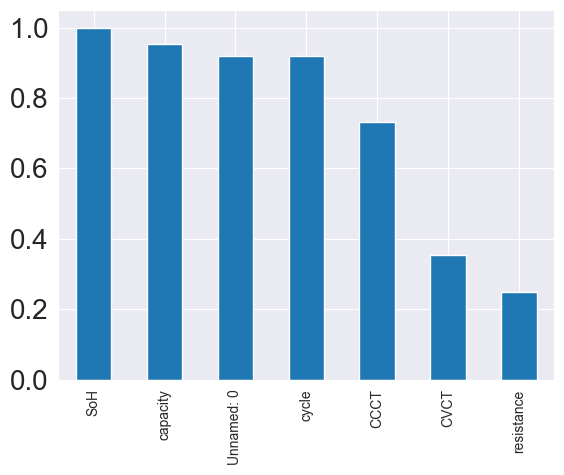

In [5]:
"""相关性分析"""

import matplotlib.pyplot as plt
import pandas as pd

# 选择数值型的列
numeric_train = train.select_dtypes(include=[np.number])

# 计算相关系数
corr_matrix = numeric_train.corr()

# 提取与 SalePrice 列相关的绝对相关系数，并排序
sorted_corr = abs(corr_matrix['SoH']).sort_values(ascending=False)

# 绘制条形图
sorted_corr.plot.bar()
plt.xticks(fontsize=10)
plt.yticks(fontsize=20)

# 显示图形
plt.show()

D:\python\project\数据解析\Lib\site-packages\seaborn\axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
D:\python\project\数据解析\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
D:\python\project\数据解析\Lib\site-packages\seaborn\axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
D:\python\project\数据解析\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
D:\python\project\数据解析\Lib\site-packages\seaborn\axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
D:\python\project\数据解析\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has cha

<Figure size 1200x800 with 0 Axes>

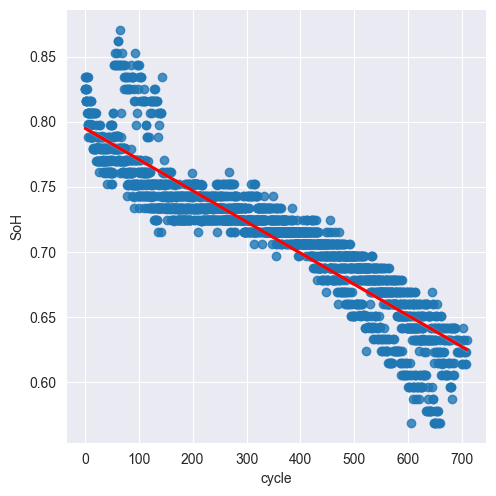

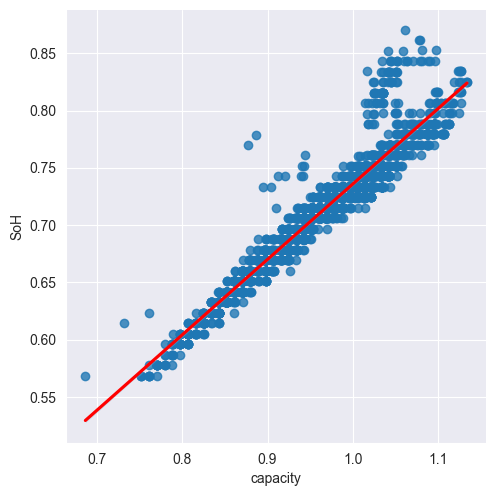

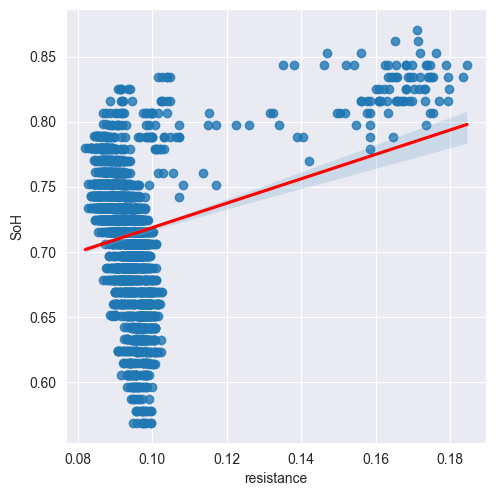

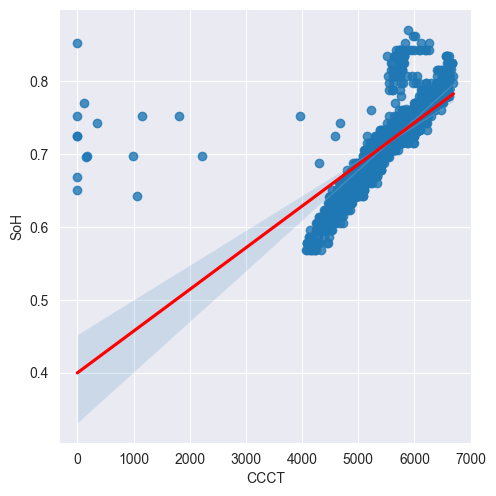

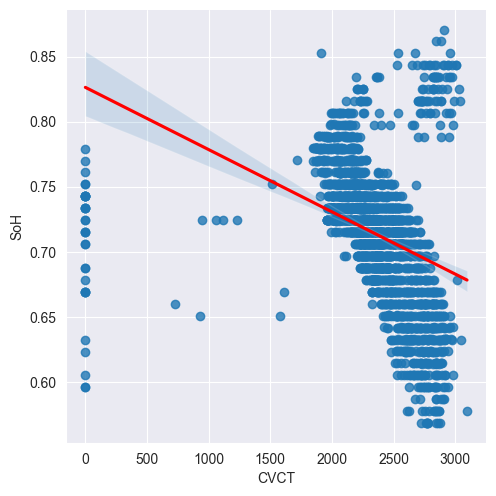

In [6]:
"""异常值分析"""
figure=plt.figure(figsize=(12, 8))
pair_grid1=sns.pairplot(x_vars=['cycle'],y_vars=['SoH'],
             data=train,dropna=True,size=5,kind="reg")
# 遍历生成的图形  
for ax in pair_grid1.axes.flat:  
    # 检查当前轴是否有一个回归线（可能是一个 Line2D 对象）  
    for line in ax.lines:  
        # 更改回归线的颜色  
        line.set_color('red')  # 你可以设置为你想要的任何颜色  

pair_grid2=sns.pairplot(x_vars=['capacity'],y_vars=['SoH'],
             data=train,dropna=True,size=5,kind="reg")

# 遍历生成的图形  
for ax in pair_grid2.axes.flat:  
    # 检查当前轴是否有一个回归线（可能是一个 Line2D 对象）  
    for line in ax.lines:  
        # 更改回归线的颜色  
        line.set_color('red')  # 你可以设置为你想要的任何颜色  

pair_grid3=sns.pairplot(x_vars=['resistance'],y_vars=['SoH'],
             data=train,dropna=True,size=5,kind="reg")

# 遍历生成的图形  
for ax in pair_grid3.axes.flat:  
    # 检查当前轴是否有一个回归线（可能是一个 Line2D 对象）  
    for line in ax.lines:  
        # 更改回归线的颜色  
        line.set_color('red')  # 你可以设置为你想要的任何颜色  

pair_grid4=sns.pairplot(x_vars=['CCCT'],y_vars=['SoH'],
             data=train,dropna=True,size=5,kind="reg")

# 遍历生成的图形  
for ax in pair_grid4.axes.flat:  
    # 检查当前轴是否有一个回归线（可能是一个 Line2D 对象）  
    for line in ax.lines:  
        # 更改回归线的颜色  
        line.set_color('red')  # 你可以设置为你想要的任何颜色  

pair_grid5=sns.pairplot(x_vars=['CVCT'],y_vars=['SoH'],
             data=train,dropna=True,size=5,kind="reg")

# 遍历生成的图形  
for ax in pair_grid5.axes.flat:  
    # 检查当前轴是否有一个回归线（可能是一个 Line2D 对象）  
    for line in ax.lines:  
        # 更改回归线的颜色  
        line.set_color('red')  # 你可以设置为你想要的任何颜色  



plt.show()

In [7]:
"""缺失值填充"""
# 用含有缺失值列的中位数
for col in null_name:
    median_value = dataset_df[col].median()
    
    dataset_df[col].fillna(median_value, inplace=True)
null_per = dataset_df.isnull().sum()
null_per[null_per > 0].sort_values(ascending=False)
dataset_df.head(100)

,cycle,capacity,SoH,resistance,CCCT,CVCT,CS_Name
0,1,1.126385,0.825175,0.094009,6613.059052,2251.498033,CS2_35
1,2,1.126160,0.815965,0.091661,6612.402800,2231.967052,CS2_35
2,3,1.125966,0.815977,0.094649,6608.560673,2228.216959,CS2_35
3,4,1.118508,0.825194,0.091413,6604.732222,2247.561061,CS2_35
4,5,1.117210,0.806900,0.091413,6629.211049,2077.692393,CS2_35
...,...,...,...,...,...,...,...
95,96,1.016196,0.751706,0.092305,1800.907467,2492.444326,CS2_35
96,97,1.015519,0.751713,0.092305,3954.826842,2218.207348,CS2_35
97,98,1.014264,0.751727,0.093840,5913.553310,2217.348202,CS2_35
98,99,1.022954,0.742641,0.090686,5899.742220,2214.817269,CS2_35


In [8]:

"""异常值清理"""

dataset_df = dataset_df.drop(dataset_df[(dataset_df['CCCT'] < 2000)].index)
dataset_df = dataset_df.drop(dataset_df[(dataset_df['CVCT'] < 1000)].index)
dataset_df = dataset_df.drop(dataset_df[(dataset_df['SoH'] < 0)].index)
dataset_df.to_csv('../数据/clean_train.csv', index=False)

In [9]:
"""清理测试集"""
clean_test=test.drop(test[(test['SoH'] > 0)].index)

# 计算列的中位数
median_value1 = clean_test['CVCT'].median()

# 使用中位数填充列中的缺失值
clean_test['CVCT'].fillna(median_value1, inplace=True)

clean_test.loc[clean_test['CVCT'] == 0.0, 'CVCT'] = median_value1


clean_test.drop(['Unnamed: 0'], axis=1, inplace=True)
clean_test.drop(['SoH'], axis=1, inplace=True)
clean_test.to_csv('../数据/clean_test.csv', index=False)
